### Simulation and storing of data

In [2]:
from Vehicle import Vehicle
from Agent import Agent
from limo import Limo
from visualization import map_lanes_multi, map_tube_multi, map_city_block_multi, map_circle_multi, make_boat_scenario, make_boat_scenario_bigger, make_Ravnkloa, Visualization

import pygame
import numpy as np;

**Simulate cars**

In [2]:
# Create a visualizer
#objects, cars = map_lanes_multi(viz=False)
#objects, cars = map_tube_multi(viz=False, dt=1/60) # 60FPS
objects, cars = map_city_block_multi(viz=False)

# Spawn drivers
alpha_max = 1.2
v_max = 7 # 6 
v_min = -2 
limos = []
for car in cars:
    agent = Agent(v_max, v_min, alpha_max)
    # Make it a limo!
    limo = Limo(vehicle=car, driver=agent)
    limos.append(limo)

# Sets certain parameters
steps = 10000
# TODO: move these params to the agent?
alpha_refs = np.zeros(len(cars))
v_refs = np.ones(len(cars))*2
# Book-keeping
all_sides = np.zeros((steps, len(cars), 4, 2, 2))
headings = np.zeros((steps, len(cars))) # angle
directions = np.zeros((steps, len(cars))) # Sign
positions_center = np.zeros((steps, len(cars), 2))
velocity_normed = np.zeros((steps, len(cars)))
steering_angle = np.zeros((steps, len(cars)))
############
break_flag = False
for i in range(steps):
    if break_flag:
        break
    # Generate circogram
    N = 36
    horizon = 500
    # Circograms!
    DCs = []
    SCs = []
    for n, car in enumerate(cars):
        static_circogram = car.static_circogram_2(N, objects[0:n]+objects[n+1:], horizon)
        dynamic_circogram = car.dynamic_cicogram_2(static_circogram, alpha_refs[n], v_refs[n], seconds=3)
        d1, d2, _, _, _ = static_circogram
        car.collision_check(d1, d2)
        DCs.append(dynamic_circogram)
        SCs.append(static_circogram)
        #########################################
        all_sides[i, n] = np.asarray(car.sides)
        headings[i, n] = car.heading
        positions_center[i, n] = car.position_center
        directions[i, n] = car.actual_direction
        steering_angle[i, n] = car.alpha # Current steering angle
        if car.actual_direction:
            velocity_normed[i, n] = np.linalg.norm(car.X[2:])*car.actual_direction
        else:
            velocity_normed[i, n] = np.linalg.norm(car.X[2:])
        #########################################

        if car.collided:
            # Requires manual restart
            print("A car collided at", i*100/steps, "%")
            steps = i - 20 # Go a bit back in time
            break_flag = True

    ##############
    # Kinematics #
    ##############
    for n, limo in enumerate(limos):
        if not limo.vehicle.collided:
            v_refs[n], alpha_refs[n] = limo.driver.determined_driver(DCs[n], SCs[n], v_refs[n], alpha_refs[n], risk_threshold=1.5, stop_threshold = 4,  dist_wait=10, verbose=False) # Good with city block
        else:
            v_refs[n], alpha_refs[n] = (0, 0)
        # Run one step
        limo.vehicle.one_step_algorithm(alpha_ref=alpha_refs[n], v_ref=v_refs[n])


KeyboardInterrupt: 

#### Simulate boats

In [3]:
divider = 10
dt = 1/divider
objects, cars = make_Ravnkloa(scale_boat_phys=5.0, viz=False, dt=dt) # 60FPS

# Spawn drivers
alpha_max = 0.8
v_max = 3 
v_min = -1 
limos = []
for car in cars:
    agent = Agent(v_max, v_min, alpha_max)
    # Make it a limo!
    limo = Limo(vehicle=car, driver=agent)
    limos.append(limo)

# Sets certain parameters
steps = 2000 # <<<<<---------------------------------------------CHANGE NUMBER OF STEPS HERE
# TODO: move these params to the agent?
alpha_refs = np.zeros(len(cars))
v_refs = np.ones(len(cars))*2
# Book-keeping
all_sides = np.zeros((steps, len(cars), 4, 2, 2))
headings = np.zeros((steps, len(cars))) # angle
directions = np.zeros((steps, len(cars))) # Sign
positions_center = np.zeros((steps, len(cars), 2))
velocity_normed = np.zeros((steps, len(cars)))
steering_angle = np.zeros((steps, len(cars)))
############
break_flag = False
for i in range(steps):
    if i % 100 == 0:
        print("Progress: ", i*100/steps, "%")
    if break_flag:
        break
    
    if i %(divider//6) == 0: # Only act every 0.1 seconds 
        # Generate circogram
        N = 36
        horizon = 500
        DCs = []
        SCs = []
        for n, car in enumerate(cars):
            static_circogram = car.static_circogram_2(N, objects[0:n]+objects[n+1:], horizon)
            dynamic_circogram = car.dynamic_cicogram_2(static_circogram, alpha_refs[n], v_refs[n], seconds=3)
            d1, d2, _, _, _ = static_circogram
            car.collision_check(d1, d2)
            DCs.append(dynamic_circogram)
            SCs.append(static_circogram)
            #if car.collided:
            #    # Requires manual restart
            #    print("A car collided at", i*100/steps, "%")
            #    steps = i - 20 # Go a bit back in time
            #    break_flag = True

        for n, limo in enumerate(limos):
            if not limo.vehicle.collided:
                #v_refs[n], alpha_refs[n] = limo.driver.determined_driver(DCs[n], SCs[n], v_refs[n], alpha_refs[n], risk_threshold=1.5, stop_threshold = 4,  dist_wait=10, verbose=False) # Good with city block
                v_refs[n], alpha_refs[n] = limo.driver.determined_driver(DCs[n], SCs[n], v_refs[n], alpha_refs[n], risk_threshold=0.4, stop_threshold = 2,  dist_wait=10, verbose=False) # Good in circle
            else:
                v_refs[n], alpha_refs[n] = (0, 0)
            # Run one step

    ##############
    # Kinematics #
    ##############
    for n, car in enumerate(cars):
        car.one_step_algorithm(alpha_ref=alpha_refs[n], v_ref=v_refs[n])
        #########################################
        all_sides[i, n] = np.asarray(car.sides)
        headings[i, n] = car.heading
        positions_center[i, n] = car.position_center
        directions[i, n] = car.actual_direction
        steering_angle[i, n] = car.alpha # Current steering angle
        if car.actual_direction:
            velocity_normed[i, n] = np.linalg.norm(car.X[2:])*car.actual_direction
        else:
            velocity_normed[i, n] = np.linalg.norm(car.X[2:])
        #########################################


Progress:  0.0 %
Progress:  5.0 %
Progress:  10.0 %
Progress:  15.0 %
Progress:  20.0 %
Progress:  25.0 %
Progress:  30.0 %
Progress:  35.0 %
Progress:  40.0 %
Progress:  45.0 %
Progress:  50.0 %
Progress:  55.0 %
Progress:  60.0 %
Progress:  65.0 %
Progress:  70.0 %
Progress:  75.0 %
Progress:  80.0 %
Progress:  85.0 %
Progress:  90.0 %
Progress:  95.0 %


**Plot to check that it is good data**

In [4]:
import matplotlib.pyplot as plt

(-3.0, 8.0)

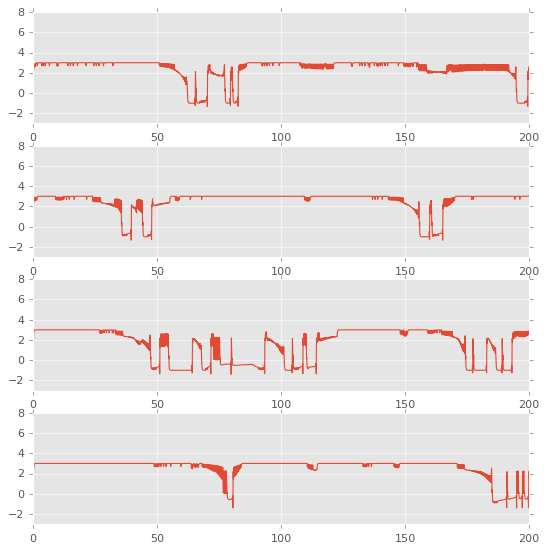

In [5]:
dt = 0.1
time_axis = np.linspace(0, steps*dt-dt, steps)
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8,8))
axs[0].plot(time_axis, velocity_normed[:steps, 0])
axs[0].set_ylim(-3, 8)
axs[1].plot(time_axis, velocity_normed[:steps, 1])
axs[1].set_ylim(-3, 8)
axs[2].plot(time_axis, velocity_normed[:steps, 2])
axs[2].set_ylim(-3, 8)
axs[3].plot(time_axis, velocity_normed[:steps, 3])
axs[3].set_ylim(-3, 8)

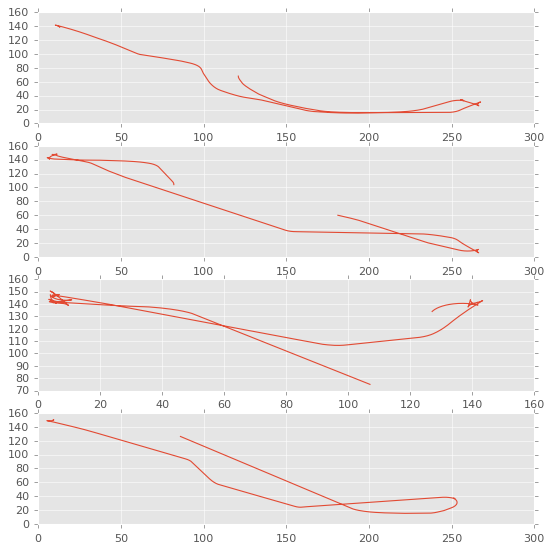

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8,8))
axs[0].plot(positions_center[:steps, 0, 0], positions_center[:steps, 0, 1])
axs[1].plot(positions_center[:steps, 1, 0], positions_center[:steps, 1, 1])
axs[2].plot(positions_center[:steps, 2, 0], positions_center[:steps, 2, 1])
axs[3].plot(positions_center[:steps, 3, 0], positions_center[:steps, 3, 1]);

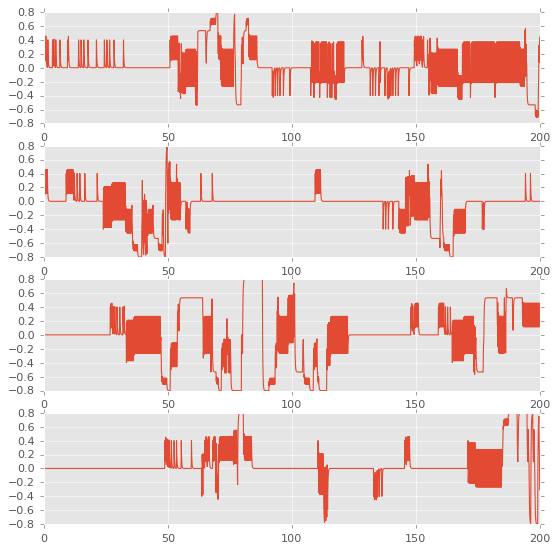

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8,8))
axs[0].plot(time_axis, steering_angle[:steps, 0])
axs[1].plot(time_axis, steering_angle[:steps, 1])
axs[2].plot(time_axis, steering_angle[:steps, 2])
axs[3].plot(time_axis, steering_angle[:steps, 3])

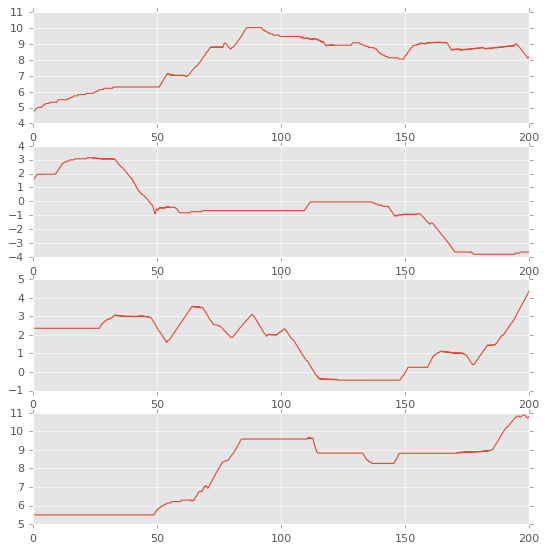

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8,8))
axs[0].plot(time_axis, headings[:steps, 0])
axs[1].plot(time_axis, headings[:steps, 1])
axs[2].plot(time_axis, headings[:steps, 2])
axs[3].plot(time_axis, headings[:steps, 3]);

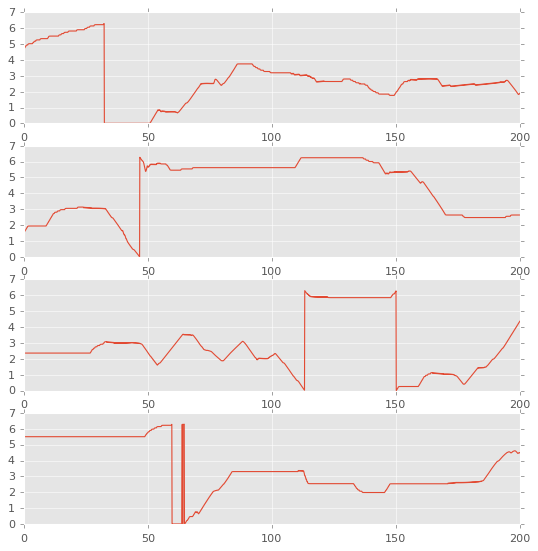

In [9]:
headings_mod = np.mod(headings, 2*np.pi)
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8,8))
axs[0].plot(time_axis, headings_mod[:steps, 0])
axs[1].plot(time_axis, headings_mod[:steps, 1])
axs[2].plot(time_axis, headings_mod[:steps, 2])
axs[3].plot(time_axis, headings_mod[:steps, 3]);

**First approach**
So, what we need is:
- Some vehicle meta-data: like length and width
- Turn rate and velocity
- center position.
- Time!


**New and improved format**
- Time is the upper level, so the json can be "streamed": https://pypi.org/project/json-stream/
- Split into three files:
    - Static env. (walls)
    - Vehicle descriptor (geometry)
    - Dynamic objects ()

In [10]:

###################
# Car descriptors #
###################
vehicle_descriptors = {}
for n, car in enumerate(cars):
    vehicle_descriptors["Boat"+str(n)] = {}
    #
    vehicle_descriptors["Boat"+str(n)]["type"] = "car"
    #
    vehicle_descriptors["Boat"+str(n)]["length_m"] = car.length
    #
    vehicle_descriptors["Boat"+str(n)]["width_m"] = car.width

############
# Dynamics #
############
dynamics = {"time_s" : {}}
time_axis = np.round(np.linspace(0, steps*dt-dt, steps), 3)
#
for step in range(steps):
    t = time_axis[step]
    dynamics["time_s"][t] = {}
    for n, car in enumerate(cars):
        #
        dynamics["time_s"][t]["Boat"+str(n)] = {}
        #
        val = np.round(velocity_normed[step, n], 3)
        dynamics["time_s"][t]["Boat"+str(n)]["normed_velocity_ms"] = val
        #
        val = np.round(steering_angle[step, n], 3)
        dynamics["time_s"][t]["Boat"+str(n)]["steering_angle_rad"] = val
        #
        val = np.round(positions_center[step, n], 3)
        dynamics["time_s"][t]["Boat"+str(n)]["center_position_m"] = val.tolist()
        #
        val = np.round(headings_mod[step, n], 3)
        dynamics["time_s"][t]["Boat"+str(n)]["heading_rad"] = val 

###########
# STATICS #
###########
static_objects = {}
outer_border = True
for n, obj in enumerate(objects):
    if isinstance(obj, Vehicle):
        continue # Already got these covered
    if outer_border:
        static_objects["OuterBorder"] = {}
        static_objects["OuterBorder"]["type"] = "wall"
        static_objects["OuterBorder"]["sides_m"] = np.asarray(obj.sides).tolist()
        outer_border = False
    else:
        obj_name = obj.get_name()
        static_objects[obj_name] = {}
        #
        static_objects[obj_name]["type"] = "wall"
        #
        static_objects[obj_name]["sides_m"] = np.asarray(obj.sides).tolist()

**Store**

In [11]:
import json
folder = "boats_in_small_fishtank"
####################################################################
# Serializing json
json_object = json.dumps(static_objects, indent=2)
# Writing to json
with open("extracted_data/"+folder+"/statics_simon.json", "w") as outfile:
    outfile.write(json_object)
####################################################################
# Serializing json
json_object = json.dumps(dynamics, indent=2)
# Writing to json
with open("extracted_data/"+folder+"/dynamics_simon.json", "w") as outfile:
    outfile.write(json_object)
####################################################################
# Serializing json
json_object = json.dumps(vehicle_descriptors, indent=2)
# Writing to json
with open("extracted_data/"+folder+"/vehicle_characteristics_simon.json", "w") as outfile:
    outfile.write(json_object)

**Loading**

In [12]:
import json
import json_stream
import time

folder = "boats_in_small_fishtank"
# Opening JSON file
f = open("extracted_data/"+folder+"/dynamics.json")
# Opening JSON file
g = open("extracted_data/"+folder+"/statics.json")
# Opening JSON file
h = open("extracted_data/"+folder+"/vehicle_characteristics.json")

# Returns JSON object as a dictionary stream
data_dynamic = json_stream.load(f, persistent=True)
data_static = json.load(g)
metadata = json.load(h)

# Close static file
g.close()
h.close()


# Start streaming
time_stream = data_dynamic["time_s"]
#last_time = time.time()

# Use the data
MAP_DIMENSIONS = (1080, 1080)
gfx = Visualization(MAP_DIMENSIONS, pixels_per_unit=10) # Also initializes the display
old_time = time.time()
for i, t in enumerate(time_stream):
    if i%60==0 and i != 0: # one second of sim
        new_time = time.time()
        print("Speed:", np.round(1/(new_time-old_time),2),"%")
        old_time = new_time
    for event in pygame.event.get():
        if event.type == pygame.QUIT: # Press x button
            exit()
    #if i%10 == 0:
    #    now_time = time.time()
    #    print(now_time-last_time)
    #    last_time = now_time
            
    ##################
    gfx.clear_canvas()
    ##################

    # Iterating through the cars
    for car in time_stream[t].keys():
        # Extract geometry
        length=metadata[car]["length_m"]
        width=metadata[car]["width_m"]
        center_pos = time_stream[t][car]["center_position_m"]
        heading = time_stream[t][car]["heading_rad"]
        
        # Vertices:
        verticesCCF = [np.array([width/2,  length/2 ]),
                       np.array([-width/2, length/2 ]),
                       np.array([-width/2, -length/2]),
                       np.array([width/2,  -length/2])]
        
        angle = heading-np.pi/2
        R_W_V = np.array([[np.cos(angle), -np.sin(angle)],
                          [np.sin(angle), np.cos(angle)]])
        
        verticesWCF = []
        for vertex in verticesCCF:
            verticesWCF.append(R_W_V@vertex + np.asarray(center_pos))
        # Sides
        sides = [[verticesWCF[-1], verticesWCF[0]]]
        for i in range(len(verticesWCF)-1):
            sides.append([verticesWCF[i], verticesWCF[i+1]])

        gfx.draw_sides(sides)
        gfx.draw_center_and_headings_simple(heading, center_pos)
    
    # Itarate static obstacles
    for wall in data_static.keys():
        gfx.draw_sides(data_static[wall]["sides_m"])

    ##################
    gfx.update_display()
    ##################


# Closing streaming file
f.close()

ModuleNotFoundError: No module named 'json_stream'